# Deep feed-forward networks
## a.k.a. multi-layer percpetrons
#### Gunnar Blohm

### Outline

- motivation and general structure
- transfer functions
- cost function and maximum likelihood estimation (MLE)
- gradient learning: error backpropagation

### Motivation and general structure

**Goal**: approximate $\vec{y} = f^*(\vec{x})$

**Approach**: learn $\vec{\theta}$ for $\vec{y} = f(\vec{x},\vec{\theta})$ so that $f \longrightarrow f^*$

### Motivation and general structure

![MLP image](stuff/MLP.png)

### Transfer functions

a.k.a. activation functions (can also contain bias terms...) 

![transfer function](stuff/transfer-function.jpg)

### Transfer functions

Transfer functions can have many different shapes...

![different transfer functions](stuff/transfer-functions.png)

### Cost functions and MLE

Most modern networks are trained using MLE. I.e. the cost function is the negative log-likelihood = cross-entropy between training data and model distribution!

$$J(\theta)=-\mathbb{E}_{x,y \sim \hat{p}_{data}} \log p_{model}(y|x)$$

if $p_{model}(y|x)=\mathcal{N}(y; f(x;\theta), I)$, then we get the mean squared error cost function:

$$ J(\theta)=\frac{1}{2}\mathbb{E}_{x,y \sim \hat{p}_{data}} \Vert y - f(x; \theta) \Vert^2 + const$$

### Cost functions and MLE

Ultimately, we want to minimize this cost to approximate $f$ with $f^*$

$$ f^* = \underset{f}{\arg\min} \mathbb{E}_{x,y \sim \hat{p}_{data}} \Vert y - f(x; \theta) \Vert^2$$

To do so, we will use gradient descent!

### Gradient learning

<img src="stuff/node.png" alt="1-layer" width="200" align="right"/>

We want to learn the weights $w_{ij}$ so that $w_{ij} \longleftarrow w_{ij}+\Delta w_{ij}$. We will use gradient descent just like previously...

$$\Delta w_{ij} = -\epsilon \frac{dJ}{dw_{ij}}$$

### Gradient learning

<img src="stuff/chain.png" alt="chain" width="50" align="right"/>

To compute $\frac{dJ}{dw_{ij}}$, we will use the chain rule.

Reminder: 

$$\frac{dz}{dw} = \frac{dz}{dy} \frac{dy}{dx} \frac{dx}{dw}$$

### Gradient learning

<img src="stuff/node.png" alt="1-layer" width="200" align="right"/>

Thus, for a 2-layer network we get (whiteboard...):

$$\Delta w_{ij}=-\epsilon \cdot g'(h_i) \cdot (r_i^{out} - y_i) \cdot r_j^{in}$$

with $h_i = \sum_{j} w_{ij} r_j^{in}$

### Gradient learning

For multi-layer networks, the procedure is the same, but now you have longer derivatives chains...

3-layer network: $\frac{\partial J}{\partial w_{ij}^{out}} = \delta_i^{out} \cdot r_j^h$

with $ \delta_i^{out} = g'^{out}(h_i^h) \cdot (r_i^{out} - y_i) $

Now for $w_{ij}^h$, we get:

$$\frac{\partial J}{\partial w_{ij}^{h}} = \frac{1}{2} \frac{1}{\partial w_{ij}^{h}} \sum_{i} \left (g^{out} \left (\sum_{j} w_{ij}^{out} g^h \left (\sum_{k} w_{jk}^h r_k^{in} \right ) \right ) - y_i \right )^2$$

$$ = \delta_i^h \cdot r_j^{in}$$

with $ \delta_i^h = g'(h_i^{in}) \sum_{k} w_{ik}^{out} \delta_k^{out} $. **This is back-propagation of error $\delta$!**

### Backprop

<img src="stuff/Mazzoni.png" alt="Mazzoni" width="400" align="right"/>

Now let's try to implement this by reproducing [Zipser & Andersen (1988). A back-propagation programmed network that simulates response properties of a subset of posterior parietal neurons](https://www.nature.com/articles/331679a0).



**Network task (training set)**: Add 2 variables coded in distributed neural population codes

(Figure from Mazzoni, Andersen & Jordan, 1991)

### Backprop

Setup...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create training set
N = 200 # length of training set
input = 50*(np.random.rand(2,N))-25
output = input[0,:] - input[1,:]

input.shape

(2, 200)

### Backprop

Network definition and initialization

In [40]:
# create network
x = np.linspace(-50,50,101) # preferred directions of input units
Ni = 2*len(x)
Nh = 21 # number hidden layer units
No = len(x) # number population output units
eps = 0.01 # learning rate
r = 0 # if r=0 --> normal packprop; if r=1 --> resilient backprop

In [41]:
# initialize weights
w1 = 1*(np.random.rand(Nh,Ni)-0.5) # random
w2 = 1*(np.random.rand(No,Nh)-0.5) # random
w3 = 1*(np.random.rand(1,No)-0.5) # random

### Backprob

We still need to define our network node transfer function (sigmoid):

$$ y = \frac{1}{1+e^{-x}} $$

In [4]:
def NTF(x):
    '''network node transfer function''' 
    y = 1/(1+np.exp(-x))
    return y

And we need to define the input activations (Gaussian population code)

In [5]:
def PPC(x, inp):
    '''Gaussian input population code''' 
    y = np.exp(-(x-inp)**2/10**2/2)
    return y

### Backprop

Now we can go into the learning loop...

In [42]:
# for housekeeping
il = np.zeros((Ni,N))
hl = np.zeros((Nh, N))
ol = np.zeros((No, N))
out = np.zeros(N)
err = np.zeros(N)
de3 = np.zeros(N)
dw3 = np.zeros((No,N))
de2 = np.zeros((No,N))
dw2 = np.zeros((No,Nh,N))
de1 = np.zeros((Nh,N))
dw1 = np.zeros((Nh,Ni,N))
ERR = []

In [47]:
for j in range(100): # training iterations
    for i in range(len(input[0,:])): # loop over training set
        # encode input
        #il[:,i] = np.block([PPC(x, input[0,i]), (input[1,i]+50)/100, -(input[1,i]-50)/100])
        il[:,i] = np.block([PPC(x, input[0,i]), PPC(x, input[1,i])])        # compute layer activations
        hl[:,i] = NTF(w1.dot(il[:,i]))
        ol[:,i] = NTF(w2.dot(hl[:,i]))
        # decode output (read-out)
        out[i] = w3.dot(ol[:,i])
        # back-propagation (gradient descent)
        err[i] = out[i] - output[i]
        de3[i] = -err[i]
        dw3[:,i] = eps*de3[i]*ol[:,i]
        de2[:,i] = w3*de3[i]
        dw2[:,:,i] = eps*np.outer(de2[:,i],hl[:,i])
        temp = np.tile(de2[:,i],(Nh,1));
        de1[:,i] = np.sum(w2.dot(temp))
        dw1[:,:,i] = eps*np.outer(de1[:,i],il[:,i])
    # update weights
    w1 = w1 + (1-r)*np.mean(dw1, axis=2) + r*eps*np.sign(np.mean(dw1, axis=2))
    w2 = w2 + (1-r)*np.mean(dw2, axis=2) + r*eps*np.sign(np.mean(dw2, axis=2))
    w3 = w3 + (1-r)*np.mean(dw3, axis=1) + r*eps*np.sign(np.mean(dw3, axis=1))
    # record error changes
    ERR.append(np.sqrt(np.sum(err**2))/N)

Text(0, 0.5, 'MSE')

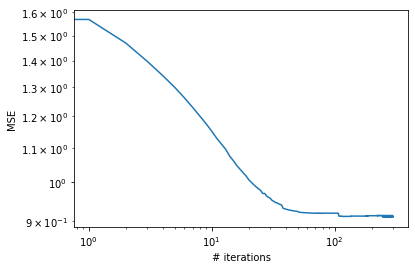

In [48]:
# plot learing curve
n = len(ERR)
xx = np.linspace(0, n, n)
plt.loglog(xx,ERR)
plt.xlabel('# iterations')
plt.ylabel('MSE')